In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

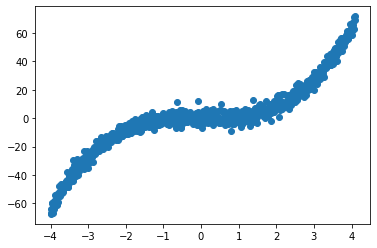

In [2]:
xs = torch.arange(-4., 4.1, 0.01)
rand = torch.empty(xs.shape).normal_(mean=0,std=3.)
ys = xs ** 3 + rand

xs.unsqueeze_(1)
ys.unsqueeze_(1)

plt.scatter(xs, ys)
total_pts = len(xs)

In [3]:
# Functions

from torch.nn import Module
import torch.nn.functional as F

def NIG_NLL(y: torch.Tensor,
            gamma: torch.Tensor,
            nu: torch.Tensor,
            alpha: torch.Tensor,
            beta: torch.Tensor, reduction='mean'):
    twoBlambda = 2*beta*(1+nu)
    nll = 0.5*torch.log(np.pi/nu) - alpha*torch.log(twoBlambda) \
          + (alpha+0.5) * torch.log(nu*(y-gamma)**2 + twoBlambda) \
          + torch.lgamma(alpha)  \
          - torch.lgamma(alpha+0.5)
    return nll.mean()

def NIG_Reg(y, gamma, nu, alpha, reduction='mean'):
    error = (y - gamma).abs()
    evidence = 2. * nu + alpha
    return (error * evidence).mean()

def EvidentialRegression(y: torch.Tensor, evidential_output: torch.Tensor, lmbda=1e-2, eps=0.):
    gamma = evidential_output[0, :]
    nu = evidential_output[1, :]
    alpha = evidential_output[2, :]
    beta = evidential_output[3, :]

    #gamma, nu, alpha, beta = evidential_output
    loss_nll = NIG_NLL(y, gamma, nu, alpha, beta)
    loss_reg = NIG_Reg(y, gamma, nu, alpha)
    return loss_nll + lmbda * (loss_reg - eps)

from torch.nn import Module
import torch.nn.functional as F

class DenseNormalGamma(Module):
    def __init__(self, n_input, n_out_tasks=1):
        super(DenseNormalGamma, self).__init__()
        self.n_in = n_input
        self.n_out = 4 * n_out_tasks
        self.n_tasks = n_out_tasks
        self.l1 = nn.Linear(self.n_in, self.n_out)

    def forward(self, x):
        x = self.l1(x)
        if len(x.shape) == 1:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=0)
        else:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=1)

        nu = F.softplus(lognu)
        alpha = F.softplus(logalpha) + 1.
        beta = F.softplus(logbeta)

        return torch.stack([gamma, nu, alpha, beta]).to(x.device)


In [4]:
from torch import nn

class BasicNetwork(torch.nn.Module):
    def __init__(self, n_in=1, n_tasks=1):
        super(BasicNetwork, self).__init__()
        self.l1 = torch.nn.Linear(n_in, 100)
        self.l2 = torch.nn.Linear(100, 100)
        self.l3 = torch.nn.Linear(100, 100)
        self.l4 = torch.nn.Linear(100, 100)
        self.l5 = DenseNormalGamma(100, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = torch.nn.functional.relu(x)
        x = self.l2(x)
        x = torch.nn.functional.relu(x)
        x = self.l3(x)
        x = torch.nn.functional.relu(x)
        x = self.l4(x)
        x = torch.nn.functional.relu(x)
        x = self.l5(x)
        return x

In [5]:
epochs = 5000

model = BasicNetwork()
optim = torch.optim.Adam(model.parameters(), lr=5e-3)
#optim = torch.optim.LBFGS(model.parameters(), lr=5e-5)
for epoch in range(epochs):
    def closure():
        output = model(xs)
        loss = EvidentialRegression(ys, output)
        if epoch%500 == 0 or epoch == 4999:
            print(f"Step {epoch}: ", loss.item())
        optim.zero_grad()
        loss.backward()
        return loss
    optim.step(closure)

Step 0:  8.838248252868652
Step 500:  2.6869401931762695
Step 1000:  2.574862003326416
Step 1500:  2.582831382751465
Step 2000:  2.560563802719116
Step 2500:  2.554502487182617
Step 3000:  2.5474510192871094
Step 3500:  2.5447142124176025
Step 4000:  2.5118396282196045
Step 4500:  2.4927148818969727
Step 4999:  2.4704625606536865


In [6]:
# Prediction

y_hat = []
y_aleatoric = []
y_epistemic = []
xs_hat = torch.arange(-6, 6.1, 0.1)
xs_hat.unsqueeze_(1)
ys_hat = xs_hat ** 3
for i, x in enumerate(xs_hat):
    output = model(x)
    gamma, nu, alpha, beta = output
    gamma, nu, alpha, beta = gamma.item(), nu.item(), alpha.item(), beta.item()
    y_hat.append(gamma)
    try:
        y_aleatoric.append((beta/(alpha-1))**0.5)
        y_epistemic.append((beta/(alpha-1)/nu)**0.5)
    except:
        y_aleatoric.append(0.)
        y_epistemic.append(0.)
        print("step x x^3 gamma nu alpha beta")
        print(i, x, x**3, gamma, nu, alpha, beta)
        
y_hat = np.array(y_hat)
y_aleatoric = np.array(y_aleatoric)
y_epistemic = np.array(y_epistemic)

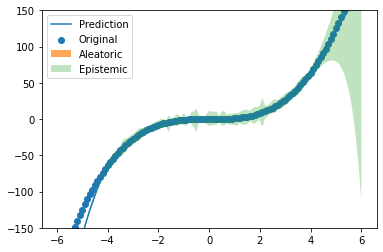

In [8]:
# Plot

plt.plot(xs_hat, y_hat, label='Prediction')
plt.scatter(xs_hat, ys_hat, label='Original')
plt.fill_between(xs_hat[:,0], y_hat-2*y_aleatoric, y_hat+2*y_aleatoric, alpha=0.7, label='Aleatoric')
plt.fill_between(xs_hat[:,0], y_hat-2*y_epistemic, y_hat+2*y_epistemic, alpha=0.3, label='Epistemic')
plt.ylim((-150, 150))
plt.legend()